In [11]:
# Load packages and directories

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from tslearn.barycenters import softdtw_barycenter 
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn_extra.cluster import KMedoids 
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram, linkage,  single, complete, average, ward, fcluster
from tslearn.metrics import dtw, cdist_dtw

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  # Change this to your output directory
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

In [196]:
# create combined_df
# Directory containing the household CSV files
data_dir = cleaned_data_directory

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

# Initialize an empty list to store household DataFrames
household_dfs = []

# Iterate through each CSV file in the directory
for filename in os.listdir(data_dir):
    if filename.endswith("_profile.csv"):
        file_path = os.path.join(data_dir, filename)
        
        # Load the household CSV file
        df = pd.read_csv(file_path)
        
        # Convert the 'TS' column to datetime
        df['TS'] = pd.to_datetime(df['TS'])
        
        # Set 'TS' as the index and extract 'Air_Conditioner_Load'
        df = df.set_index('TS')['Air_Conditioner_Load']
        
        # Extract site ID from the filename (assuming the filename format is 'siteid_profile.csv')
        site_id = filename.split('_')[0]
        
        # Rename the column with the site ID for clarity
        df = df.rename(site_id)
        
        # Reindex the household data to match the complete date range
        df = df.reindex(date_range)
        
        # Scale the data using MinMaxScaler for each household
        scaler = MinMaxScaler(feature_range=(0, 1))
        df = pd.DataFrame(scaler.fit_transform(df.values.reshape(-1, 1)), index=df.index, columns=[site_id])
        
        # Append the scaled household data to the list
        household_dfs.append(df)

# Concatenate all household DataFrames along the columns (axis=1)
combined_df = pd.concat(household_dfs, axis=1)

# De-fragment the DataFrame by creating a copy
combined_df = combined_df.copy()

# Reset the index and rename the 'index' column to 'Timestamp'
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index': 'Timestamp'})

# List of IDs to remove
ids_to_remove = [
    'S0024', 'S0159', 'S0318', 'S0444', 'S0470',
    'W0082', 'W0120', 'W0162', 'W0175', 'W0224',
    'W0241', 'W0243', 'W0315', 'W0324', 'W0330', 'W0310', 'W0335', "W0336",
    "W0213", "S0261", 'S0233', 'W0192', 'S0229', 'W0227', 'W0024', 'S0341', 'S0338'
]

# Drop columns based on the list of IDs to remove
combined_df = combined_df.drop(columns=ids_to_remove, errors='ignore')

# # Define the path for the CSV file
# csv_path = os.path.join(base_directory, 'combined_aircon_profiles_normalized.csv')

# # Write to CSV only if the file doesn't already exist
# if not os.path.exists(csv_path):
#     combined_df.to_csv(csv_path, index=False)
#     print(f'File written: {csv_path}')
# else:
#     print('File already exists!')

#print(combined_df.head())


KeyboardInterrupt: 

In [ ]:
# Visualize one of the sites
# Assuming `combined_df` contains the data with Timestamp and other site IDs
# Filter for the required columns: Timestamp and S0089
df_site_S0089 = combined_df[['Timestamp', 'W0348']]

# Create the plot
fig = go.Figure()

# Add the trace for S0089
fig.add_trace(go.Scatter(x=df_site_S0089['Timestamp'], 
                         y=df_site_S0089['W0348'], 
                         mode='lines',
                         name='S0089',
                         line=dict(color='royalblue', width=2)))

# Set the title and labels
fig.update_layout(
    title='Air Conditioner Load for Site S0089',
    xaxis_title='Timestamp',
    yaxis_title='Air Conditioner Load',
    xaxis=dict(
        tickformat='%Y-%m-%d %H:%M:%S',  # Format for timestamps
        tickmode='auto',
        nticks=10,  # Number of ticks on x-axis
    ),
    yaxis=dict(
        tickformat=".2f"  # Format for y-axis values
    ),
    template='plotly'
)

# Show the plot
fig.show()


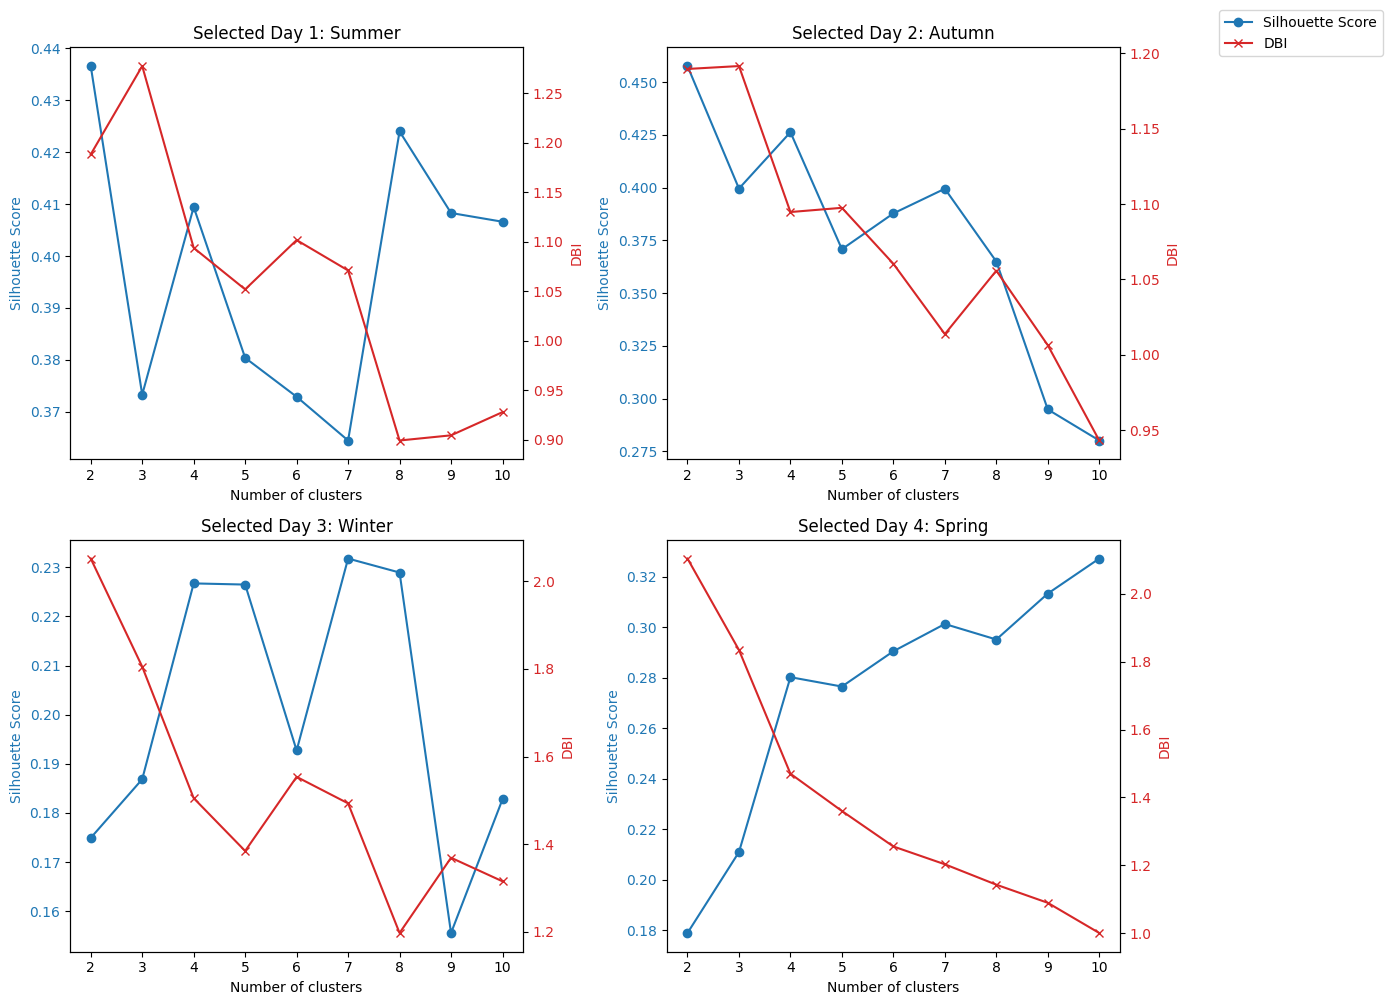

In [24]:
# Determine optimal number of clusters using four randomly selected sites, one for each season, and calculating DBi and silhouette scores


# Function to get season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Function to select random days from each season
def select_random_days(df, seed=42):
    # Set the seed for reproducibility
    random.seed(seed)
    
    # Create a 'Month' and 'Season' column
    df['Month'] = df['Timestamp'].dt.month
    df['Season'] = df['Month'].apply(get_season)
    
    # Create a dictionary to store the random day for each season
    selected_days = {}
    
    for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
        # Filter for the season
        season_df = df[df['Season'] == season]
        
        # Select a random day
        random_day = random.choice(season_df['Timestamp'].dt.date.unique())
        selected_days[season] = random_day
        
    return selected_days


# Function to calculate Silhouette and DBI scores
def kmeans_sil_dbi(num_clusters_range, x_vals):
    sil_scores = []
    dbi_scores = []
    
    
    for k in num_clusters_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x_vals)
        
        # Silhouette score (only valid for k > 1)
        if k > 1:
            sil_scores.append(mt.silhouette_score(x_vals, labels))
        else:
            sil_scores.append(None)
        
        # Davies-Bouldin Index (only valid for k > 1)
        if k > 1:
            dbi_scores.append(mt.davies_bouldin_score(x_vals, labels))
        else:
            dbi_scores.append(None)
    
    return sil_scores, dbi_scores

# Set seed and select random days
selected_days = select_random_days(combined_df, seed=42)

# Create separate DataFrames for each of the four selected days
df_day1 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[0]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
df_day2 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[1]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
df_day3 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[2]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')
df_day4 = combined_df[combined_df['Timestamp'].dt.date == list(selected_days.values())[3]].drop(columns=['Timestamp', 'Month', 'Season']).dropna(axis=1, how='all')


# List of day names and their corresponding DataFrames
season = [
    (f"Selected Day 1: {list(selected_days.keys())[0]}", df_day1),
    (f"Selected Day 2: {list(selected_days.keys())[1]}", df_day2),
    (f"Selected Day 3: {list(selected_days.keys())[2]}", df_day3),
    (f"Selected Day 4: {list(selected_days.keys())[3]}", df_day4)
]

# Range of clusters to evaluate
num_clusters_range = range(2, 11)

# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through each day + DataFrame combination
for idx, (day_name, df) in enumerate(season):
    # Drop the 'Timestamp' column for clustering
    x_vals = df

    # Calculate silhouette and DBI for the current dataset
    sil_scores, dbi_scores = kmeans_sil_dbi(num_clusters_range, x_vals)
    
    # Create a dual-axis plot for both Silhouette and DBI
    ax1 = axes[idx]
    
    # Plot silhouette score on the left y-axis
    color1 = 'tab:blue'
    ax1.plot(num_clusters_range, sil_scores, color=color1, marker="o", label="Silhouette Score")
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_title(f'{day_name}')
    
    # Create a second y-axis for DBI
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(num_clusters_range, dbi_scores, color=color2, marker="x", label="DBI")
    ax2.set_ylabel('DBI', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
# Combine both legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [ ]:


def compute_distance_matrix(df):
    n_sites = len(df.columns) - 1  # Excluding timestamp column
    distance_matrix = np.zeros((n_sites, n_sites))
    
    for i in range(n_sites):
        for j in range(i+1, n_sites):
            series1 = df.iloc[:, i+1].values  # +1 to skip timestamp column
            series2 = df.iloc[:, j+1].values
            distance_matrix[i, j] = dtw(series1, series2)
            distance_matrix[j, i] = distance_matrix[i, j]  # DTW is symmetric
    
    return distance_matrix

def evaluate_clusters(df, linkage_matrix, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    original_data = df.dropna(axis=1, how='all').iloc[:, 1:].T.values  # Transpose to get features as columns

    for n_clusters in range(4, max_clusters + 1):
        labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

        silhouette_scores.append(mt.silhouette_score(original_data, labels))
        dbi_scores.append(mt.davies_bouldin_score(original_data, labels))
    
    return silhouette_scores, dbi_scores

def calculate_combined_metric(silhouette_scores, dbi_scores):
    # Normalize scores to [0, 1] range
    scaler = MinMaxScaler()
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten()
    
    # Invert DBI scores so that higher is better
    inverted_dbi = 1 - normalized_dbi
    
    # Calculate combined metric (simple average)
    combined_metric = (normalized_silhouette + inverted_dbi) / 2
    
    return combined_metric

def optimize_clusters_for_day(day_df, max_clusters=10): 
    distance_matrix = compute_distance_matrix(day_df.dropna(axis=1, how='all'))
    linkage_matrix = linkage(distance_matrix, method='ward')
    day_df.set_index('Timestamp', inplace=True)

    # Apply linear interpolation on all columns (each representing a site ID)
    day_df = day_df.interpolate(method='linear')
    # If needed, reset the index to bring back 'Timestamp' as a column
    day_df.reset_index(inplace=True)
    silhouette_scores_1, dbi_scores_1 = evaluate_clusters(day_df.dropna(axis=1, how='all'), linkage_matrix, max_clusters) 

    scaler = MinMaxScaler()
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores_1).reshape(-1, 1)).flatten()
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores_1).reshape(-1, 1)).flatten()
    # Invert DBI scores so that higher is better
    inverted_dbi = 1 - normalized_dbi

    # Calculate combined metric (simple average)
    combined_metric = (normalized_silhouette + inverted_dbi) / 2
    # Find the optimal number of clusters
    optimal_clusters = combined_metric.argmax() + 4 
    optimal_silhouette = silhouette_scores_1[optimal_clusters - 4]
    optimal_dbi = dbi_scores_1[optimal_clusters - 4]
    optimal_score = combined_metric[optimal_clusters - 4]

    return optimal_clusters, optimal_silhouette, optimal_dbi, optimal_score


def main(df):

    # Load your data
    df = df
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])   

    daily_optimal_clusters = []
    for date, day_df in df.groupby(df['Timestamp'].dt.date): 
        daily_results = optimize_clusters_for_day(day_df) 
        optimal_clusters, optimal_silhouette, optimal_dbi, optimal_score = daily_results
        daily_optimal_clusters.append({
                'Date': date,
                'Hierarchical_OptimalClusters': optimal_clusters,
                'Hierarchical_Score': optimal_score,
                'Hierarchical_Silhouette': optimal_silhouette,
                'Hierarchical_DBI': optimal_dbi
            })
        results_df = pd.DataFrame(daily_optimal_clusters) 
        results_df['Date'] = pd.to_datetime(results_df['Date'])
        # results_df = results_df.sort_values('Date') # Save results to CSV
        # results_df.to_csv('daily_optimal_clusters.csv', index=False)
        print("Daily optimal clusters processed for date:", date)
    return results_df

cleaned_combined_df = combined_df.drop(columns=['Month', 'Season'], errors = 'ignore')

clipped_df = cleaned_combined_df[(cleaned_combined_df['Timestamp'] >= '2023-01-01') & (cleaned_combined_df['Timestamp'] <= '2023-12-31 23:30:00')]

results_df = main(clipped_df)
#results_df.to_csv('hierarchical_optimal_cluster_results.csv')



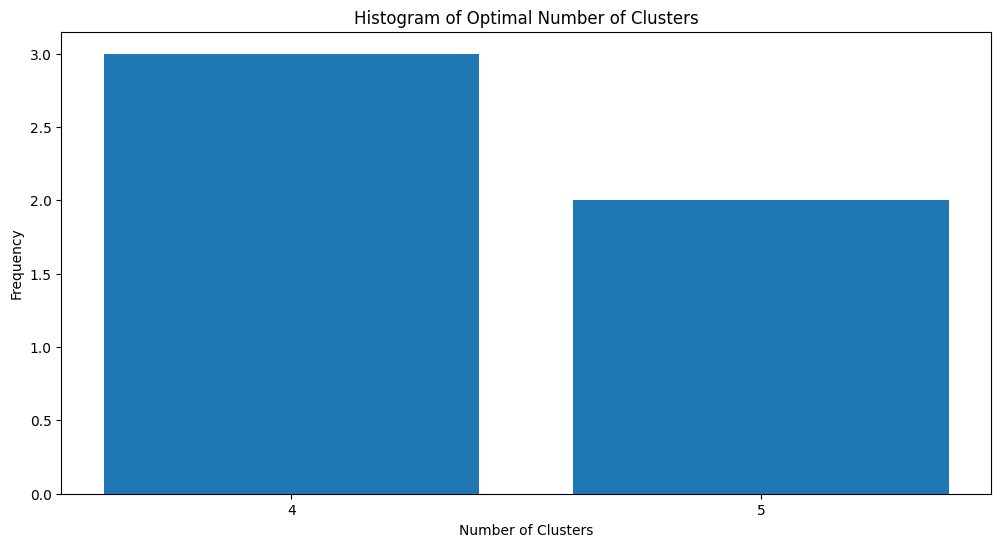

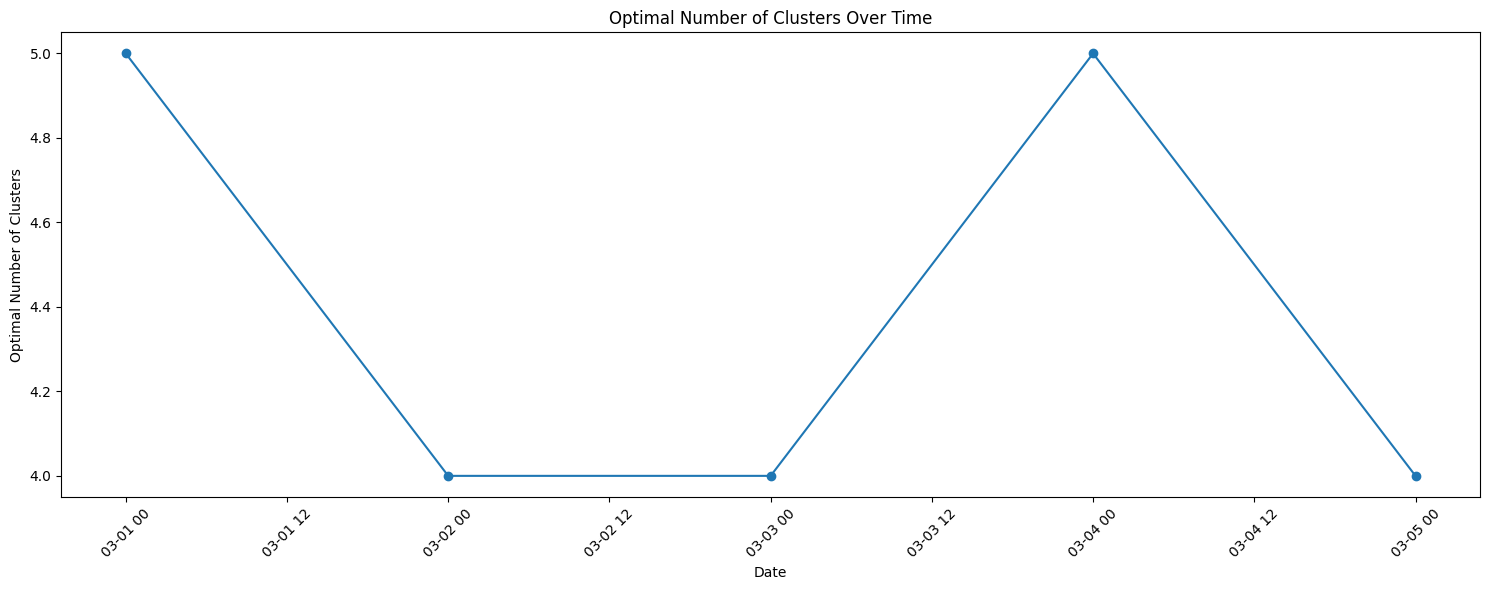

In [114]:

# Plot histogram 


plt.figure(figsize=(12, 6)) 
plt.hist(results_df['DTW_OptimalClusters'], bins=range(min(results_df['DTW_OptimalClusters']), max(results_df['DTW_OptimalClusters'])+2, 1), align='left', rwidth=0.8) 
plt.title('Histogram of Optimal Number of Clusters') 
plt.xlabel('Number of Clusters') 
plt.ylabel('Frequency') 
plt.xticks(range(min(results_df['DTW_OptimalClusters']), max(results_df['DTW_OptimalClusters'])+1)) 
plt.show()

#Plot line graph 
plt.figure(figsize=(15, 6)) 
plt.plot(results_df['Date'], results_df['DTW_OptimalClusters'], marker='o') 
plt.title('Optimal Number of Clusters Over Time') 
plt.xlabel('Date') 
plt.ylabel('Optimal Number of Clusters') 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [111]:
# Create Optimal Cluster Number using k-medoids and kmeans with dtw metric



def evaluate_clusters_dtw(X, max_clusters=10): 
    silhouette_scores = [] 
    dbi_scores = [] 
    for n_clusters in range(4, max_clusters + 1): 
        kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42) 
        labels = kmeans.fit_predict(X) 
        silhouette_scores.append(silhouette_score(X, labels)) 
        dbi_scores.append(davies_bouldin_score(X, labels)) 
    return silhouette_scores, dbi_scores 

def evaluate_clusters_kmedoids(X, max_clusters=10): 
    silhouette_scores = [] 
    dbi_scores = [] 
    for n_clusters in range(4, max_clusters + 1): 
        kmedoids = KMedoids(n_clusters=n_clusters, metric="euclidean", random_state=42) 
        labels = kmedoids.fit_predict(X) 
        silhouette_scores.append(silhouette_score(X, labels, metric="euclidean")) 
        dbi_scores.append(davies_bouldin_score(X, labels)) 
    return silhouette_scores, dbi_scores 

def calculate_combined_metric(silhouette_scores, dbi_scores): 
    scaler = MinMaxScaler() 
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten() 
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten() 
    inverted_dbi = 1 - normalized_dbi 
    combined_metric = (normalized_silhouette + inverted_dbi) / 2 
    return combined_metric 

def optimize_clusters_for_day(day_df, max_clusters=10): 
    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
    day_df_cleaned = day_df_cleaned.interpolate(method = 'linear') 
    if day_df_cleaned.shape[1] <= 1: 
        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.") 
        return None 
    X_dtw = day_df_cleaned.values.T  # Transpose for DTW 
    X_kmedoids = day_df_cleaned.values  # No transpose for k-medoids 

    # DTW clustering 

    silhouette_scores_dtw, dbi_scores_dtw = evaluate_clusters_dtw(X_dtw, max_clusters) 
    combined_metric_dtw = calculate_combined_metric(silhouette_scores_dtw, dbi_scores_dtw) 
    optimal_clusters_dtw = combined_metric_dtw.argmax() + 4 
    optimal_silhouette_dtw = silhouette_scores_dtw[optimal_clusters_dtw - 4] 
    optimal_dbi_dtw = dbi_scores_dtw[optimal_clusters_dtw - 4] 
    optimal_score_dtw = combined_metric_dtw[optimal_clusters_dtw - 4] 

    # K-Medoids clustering 
    silhouette_scores_kmedoids, dbi_scores_kmedoids = evaluate_clusters_kmedoids(X_kmedoids, max_clusters) 
    combined_metric_kmedoids = calculate_combined_metric(silhouette_scores_kmedoids, dbi_scores_kmedoids) 
    optimal_clusters_kmedoids = combined_metric_kmedoids.argmax() + 4 
    optimal_silhouette_kmedoids = silhouette_scores_kmedoids[combined_metric_kmedoids.argmax()] 
    optimal_dbi_kmedoids = dbi_scores_kmedoids[combined_metric_kmedoids.argmax()] 
    optimal_score_kmedoids = combined_metric_kmedoids[combined_metric_kmedoids.argmax()] 

    return (optimal_clusters_dtw, optimal_score_dtw, optimal_silhouette_dtw, optimal_dbi_dtw, 

            optimal_clusters_kmedoids, optimal_score_kmedoids, optimal_silhouette_kmedoids, optimal_dbi_kmedoids) 
def main(df): 
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
    daily_results = [] 
    for date, day_df in df.groupby(df['Timestamp'].dt.date): 
        print(f"Processing date: {date}, data shape: {day_df.shape}") 
        optimal_result = optimize_clusters_for_day(day_df) 
        if optimal_result is not None: 
            (optimal_clusters_dtw, optimal_score_dtw, optimal_silhouette_dtw, optimal_dbi_dtw, 
             optimal_clusters_kmedoids, optimal_score_kmedoids, optimal_silhouette_kmedoids, optimal_dbi_kmedoids) = optimal_result 
            daily_results.append({ 
                'Date': date, 
                'DTW_OptimalClusters': optimal_clusters_dtw, 
                'DTW_Score': optimal_score_dtw, 
                'DTW_Silhouette': optimal_silhouette_dtw, 
                'DTW_DBI': optimal_dbi_dtw, 
                'KMedoids_OptimalClusters': optimal_clusters_kmedoids, 
                'KMedoids_Score': optimal_score_kmedoids, 
                'KMedoids_Silhouette': optimal_silhouette_kmedoids, 
                'KMedoids_DBI': optimal_dbi_kmedoids 

            }) 

        else: 
            daily_results.append({ 
                'Date': date, 
                'DTW_OptimalClusters': None, 
                'DTW_Score': None, 
                'DTW_Silhouette': None, 
                'DTW_DBI': None, 
                'KMedoids_OptimalClusters': None, 
                'KMedoids_Score': None, 
                'KMedoids_Silhouette': None, 
                'KMedoids_DBI': None 
            }) 

    results_df = pd.DataFrame(daily_results) 
    results_df['Date'] = pd.to_datetime(results_df['Date']) 
    results_df = results_df.sort_values('Date') 
    print("Daily optimal clusters comparison processed.") 
    return results_df 

# Example usage 

cleaned_combined_df = combined_df.drop(columns=['Month', 'Season'], errors='ignore') 
clipped_df = cleaned_combined_df[(cleaned_combined_df['Timestamp'] >= '2023-01-01') & (cleaned_combined_df['Timestamp'] <= '2023-01-05 23:30:00')] 
results_df = main(clipped_df) 
#results_df.to_csv('kmedoids_dtw_optimal_clusters_results_pt2.csv')
print(results_df)

C:\Users\CEEM04\AppData\Local\Temp\ipykernel_8896\1362787128.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing date: 2023-01-01, data shape: (48, 222)
Processing date: 2023-01-02, data shape: (48, 222)
Processing date: 2023-01-03, data shape: (48, 222)
Processing date: 2023-01-04, data shape: (48, 222)
Processing date: 2023-01-05, data shape: (48, 222)
Daily optimal clusters comparison processed.
        Date  DTW_OptimalClusters  DTW_Score  DTW_Silhouette   DTW_DBI  \
0 2023-01-01                    4   0.749984        0.407266  3.317816   
1 2023-01-02                    4   1.000000        0.363417  2.451842   
2 2023-01-03                    4   1.000000        0.532984  1.996919   
3 2023-01-04                    4   1.000000        0.596184  1.805260   
4 2023-01-05                    9   0.897500        0.653636  1.875070   

   KMedoids_OptimalClusters  KMedoids_Score  KMedoids_Silhouette  KMedoids_DBI  
0                         7        0.892595             0.217934      1.098984  
1                        10        1.000000             0.136379      1.398123  
2           

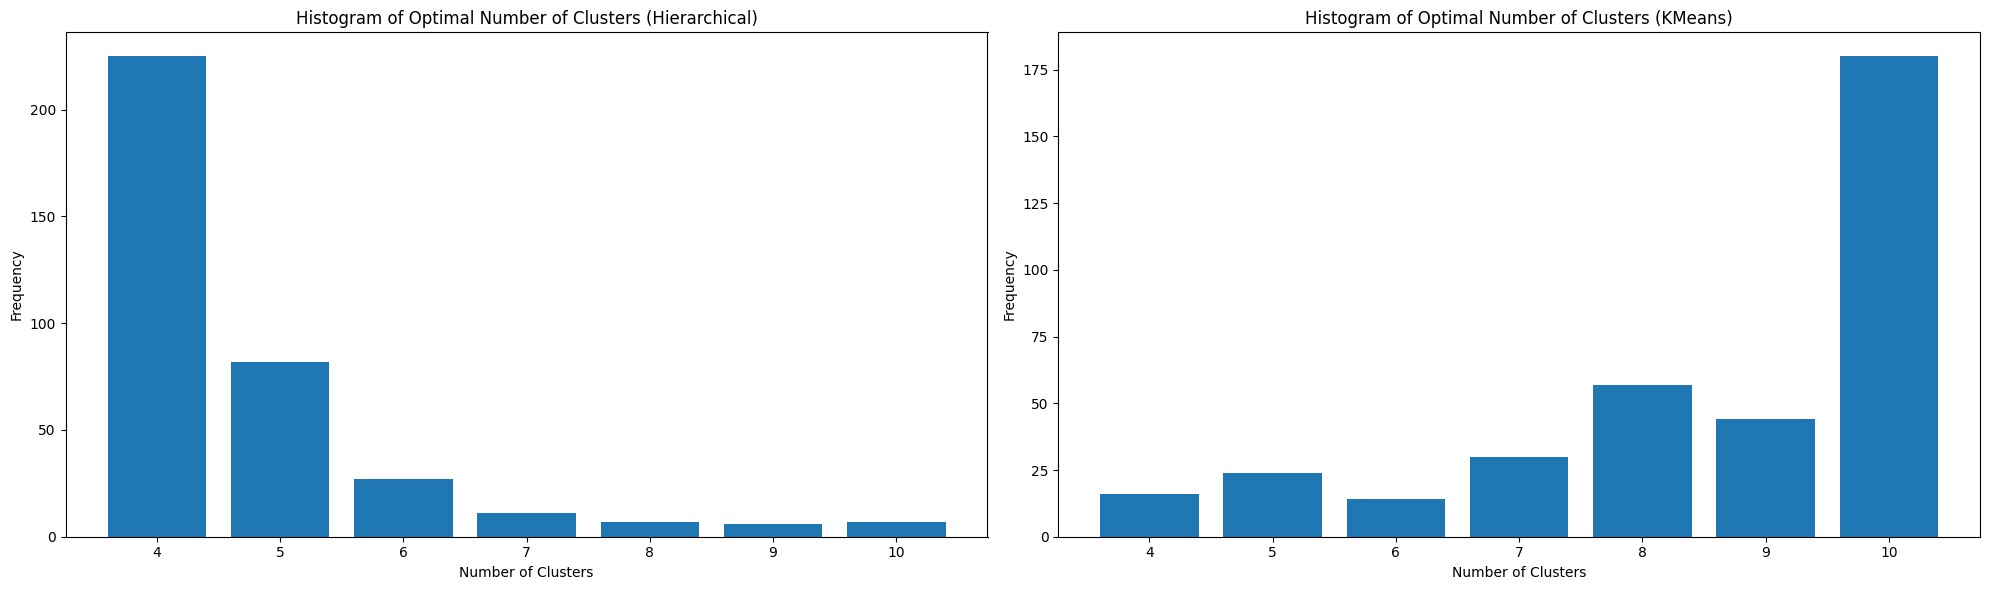

In [107]:

results_df = pd.read_csv("merged_optimal_clusters.csv")
# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(results_df['Hierarchical_OptimalClusters'], bins=range(min(results_df['Hierarchical_OptimalClusters']), max(results_df['Hierarchical_OptimalClusters'])+2, 1), 
            align='left', rwidth=0.8)
ax1.set_title('Histogram of Optimal Number of Clusters (Hierarchical)')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(min(results_df['Hierarchical_OptimalClusters']), max(results_df['Hierarchical_OptimalClusters'])+1))

ax2.hist(results_df['KMeans_OptimalClusters'], bins=range(min(results_df['KMeans_OptimalClusters']), max(results_df['KMeans_OptimalClusters'])+2, 1), 
            align='left', rwidth=0.8)
ax2.set_title('Histogram of Optimal Number of Clusters (KMeans)')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(min(results_df['KMeans_OptimalClusters']), max(results_df['KMeans_OptimalClusters'])+1))

plt.tight_layout()
plt.show()
plt.close()


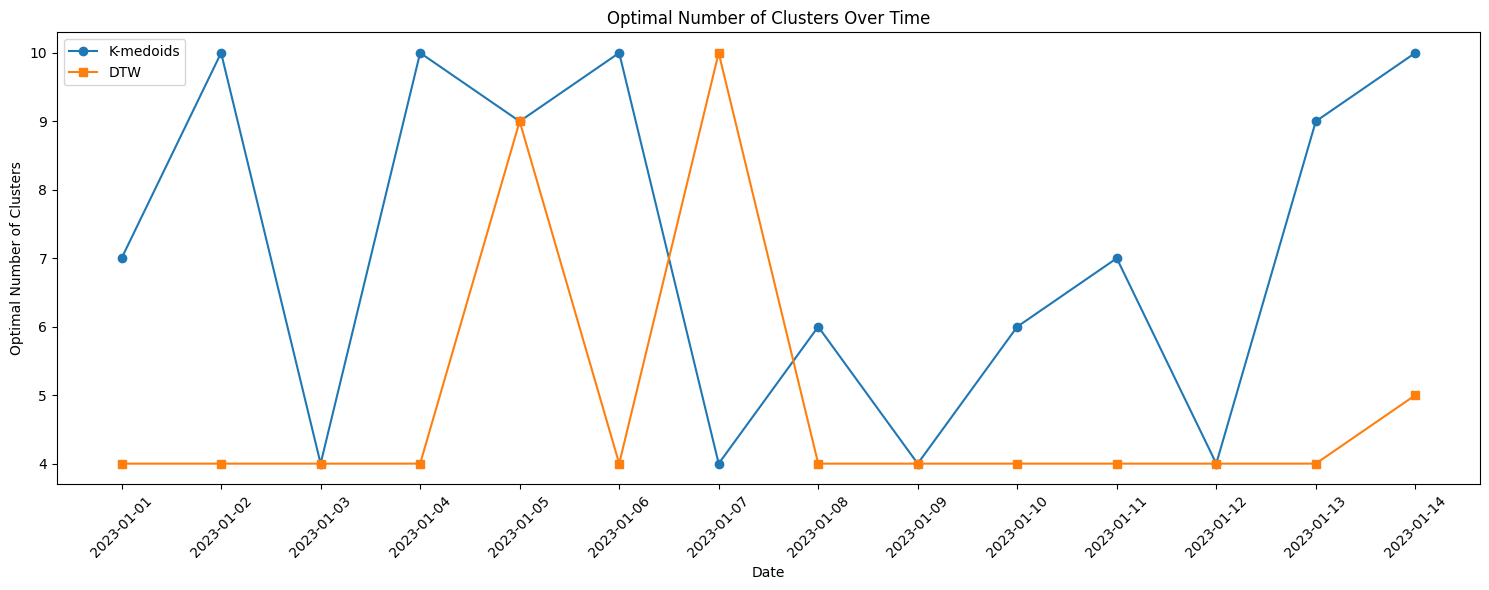

In [109]:

results_df = results_df.head(14)

# Plot line graphs
plt.figure(figsize=(15, 6))
plt.plot(results_df['Date'], results_df['KMedoids_OptimalClusters'], marker='o', label='K-medoids')
plt.plot(results_df['Date'], results_df['DTW_OptimalClusters'], marker='s', label='DTW')
plt.title('Optimal Number of Clusters Over Time')
plt.xlabel('Date')
plt.ylabel('Optimal Number of Clusters')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    



In [98]:


def evaluate_clusters_kmeans(X, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    for n_clusters in range(4, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(mt.silhouette_score(X, labels))
        dbi_scores.append(mt.davies_bouldin_score(X, labels))
    return silhouette_scores, dbi_scores

def calculate_combined_metric(silhouette_scores, dbi_scores):
    scaler = MinMaxScaler()
    normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()
    normalized_dbi = scaler.fit_transform(np.array(dbi_scores).reshape(-1, 1)).flatten()
    inverted_dbi = 1 - normalized_dbi
    combined_metric = (normalized_silhouette + inverted_dbi) / 2
    return combined_metric

def optimize_clusters_for_day(day_df, max_clusters=10):
    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
    day_df_cleaned = day_df_cleaned.interpolate(method='linear')
    if day_df_cleaned.shape[1] <= 1:
        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.")
        return None
    X = day_df_cleaned.values

    silhouette_scores, dbi_scores = evaluate_clusters_kmeans(X, max_clusters)
    combined_metric = calculate_combined_metric(silhouette_scores, dbi_scores)
    optimal_clusters = combined_metric.argmax() + 4
    optimal_silhouette = silhouette_scores[optimal_clusters - 4]
    optimal_dbi = dbi_scores[optimal_clusters - 4]
    optimal_score = combined_metric[optimal_clusters - 4]

    return (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi)

def main(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    daily_results = []
    for date, day_df in df.groupby(df['Timestamp'].dt.date):
        print(f"Processing date: {date}, data shape: {day_df.shape}")
        optimal_result = optimize_clusters_for_day(day_df)
        if optimal_result is not None:
            (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi) = optimal_result
            daily_results.append({
                'Date': date,
                'KMeans_OptimalClusters': optimal_clusters,
                'KMeans_Score': optimal_score,
                'KMeans_Silhouette': optimal_silhouette,
                'KMeans_DBI': optimal_dbi
            })
        else:
            daily_results.append({
                'Date': date,
                'KMeans_OptimalClusters': None,
                'KMeans_Score': None,
                'KMeans_Silhouette': None,
                'KMeans_DBI': None
            })

    results_df = pd.DataFrame(daily_results)
    results_df['Date'] = pd.to_datetime(results_df['Date'])
    results_df = results_df.sort_values('Date')
    print("Daily optimal clusters comparison processed.")
    return results_df

# Example usage
cleaned_combined_df = combined_df.drop(columns=['Month', 'Season'], errors='ignore')
clipped_df = cleaned_combined_df[(cleaned_combined_df['Timestamp'] >= '2023-01-01') & (cleaned_combined_df['Timestamp'] <= '2023-12-31 23:30:00')]
results_df = main(clipped_df)
results_df.to_csv('kmeans_optimal_clusters_results.csv')

Processing date: 2023-01-01, data shape: (48, 222)
Processing date: 2023-01-02, data shape: (48, 222)
Processing date: 2023-01-03, data shape: (48, 222)
Processing date: 2023-01-04, data shape: (48, 222)
Processing date: 2023-01-05, data shape: (48, 222)
Processing date: 2023-01-06, data shape: (48, 222)
Processing date: 2023-01-07, data shape: (48, 222)
Processing date: 2023-01-08, data shape: (48, 222)
Processing date: 2023-01-09, data shape: (48, 222)
Processing date: 2023-01-10, data shape: (48, 222)
Processing date: 2023-01-11, data shape: (48, 222)
Processing date: 2023-01-12, data shape: (48, 222)
Processing date: 2023-01-13, data shape: (48, 222)
Processing date: 2023-01-14, data shape: (48, 222)
Processing date: 2023-01-15, data shape: (48, 222)
Processing date: 2023-01-16, data shape: (48, 222)
Processing date: 2023-01-17, data shape: (48, 222)
Processing date: 2023-01-18, data shape: (48, 222)
Processing date: 2023-01-19, data shape: (48, 222)
Processing date: 2023-01-20, da

In [100]:
df = pd.read_csv('merged_optimal_clusters.csv')

kmeans = pd.read_csv('kmeans_optimal_clusters_results.csv')

df = pd.merge(df, kmeans, on = "Date")

df.to_csv("merged_optimal_clusters.csv")


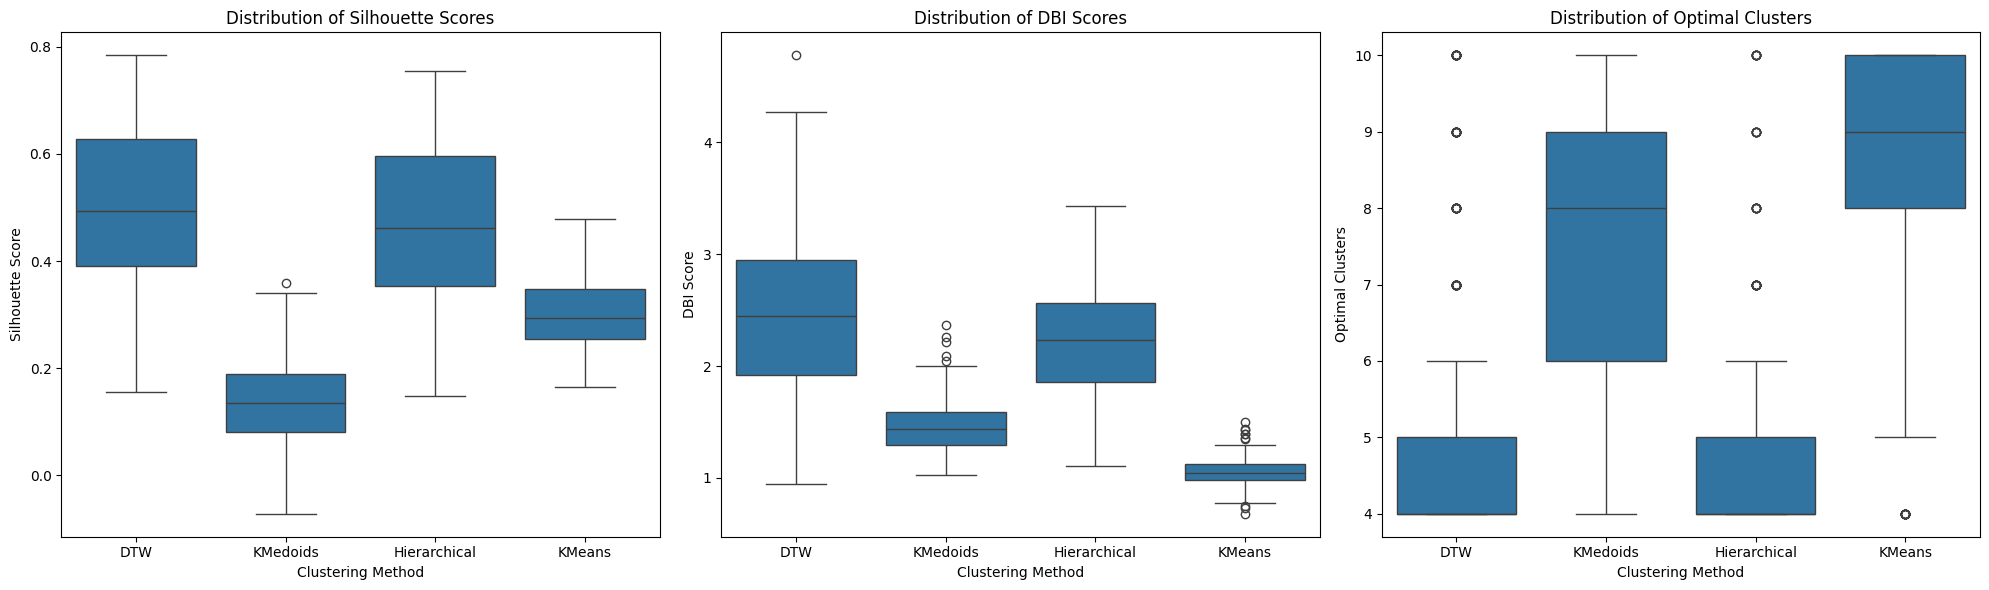

In [105]:

df = pd.read_csv('merged_optimal_clusters.csv')
# Assuming your data frame is named df
# Reshape the data for Silhouette Scores
silhouette_data = pd.melt(df, id_vars='Date', 
                          value_vars=['DTW_Silhouette', 'KMedoids_Silhouette', 'Hierarchical_Silhouette', 'KMeans_Silhouette'],
                          var_name='Clustering_Method', value_name='Silhouette_Score')
silhouette_data['Clustering_Method'] = silhouette_data['Clustering_Method'].str.replace('_Silhouette', '')


# Reshape the data for DBI Scores
dbi_data = pd.melt(df, id_vars='Date', 
                   value_vars=['DTW_DBI', 'KMedoids_DBI', 'Hierarchical_DBI', 'KMeans_DBI'],
                   var_name='Clustering_Method', value_name='DBI_Score')
dbi_data['Clustering_Method'] = dbi_data['Clustering_Method'].str.replace('_DBI', '')

optimalclusters_data = pd.melt(df, id_vars='Date', 
                   value_vars=['DTW_OptimalClusters', 'KMedoids_OptimalClusters', 'Hierarchical_OptimalClusters', 'KMeans_OptimalClusters'],
                   var_name='Clustering_Method', value_name='Optimal_Clusters')
optimalclusters_data['Clustering_Method'] = optimalclusters_data['Clustering_Method'].str.replace('_OptimalClusters', '')

# Create a figure and axes for the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))


# Plot Silhouette Scores
sns.boxplot(x='Clustering_Method', y='Silhouette_Score', data=silhouette_data, ax=ax1)
ax1.set_title('Distribution of Silhouette Scores')
ax1.set_xlabel('Clustering Method')
ax1.set_ylabel('Silhouette Score')

# Plot DBI Scores
sns.boxplot(x='Clustering_Method', y='DBI_Score', data=dbi_data, ax=ax2)
ax2.set_title('Distribution of DBI Scores')
ax2.set_xlabel('Clustering Method')
ax2.set_ylabel('DBI Score')


sns.boxplot(x = "Clustering_Method", y = "Optimal_Clusters", data = optimalclusters_data, ax = ax3)
ax3.set_title('Distribution of Optimal Clusters')
ax3.set_xlabel('Clustering Method')
ax3.set_ylabel('Optimal Clusters')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Create the histogram for Hierarchical Silhouette Scores
sns.histplot(df['KMedoids_Silhouette'], bins=10, kde=True)

# Add titles and labels
plt.title('Histogram of Hierarchical Silhouette Scores', fontsize=14)
plt.xlabel('Hierarchical Silhouette Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:


def create_cluster_grid(df, start_date, end_date, num_clusters): 
    dates = pd.date_range(start=pd.to_datetime(start_date).date(), end=pd.to_datetime(end_date).date()) 
    #fig, axes = plt.subplots(num_clusters, len(dates), figsize=(20, 20)) 
    #fig.suptitle('Clusters for Each Date', fontsize=16) 

    rlp_dict = {}
    cluster_sites_dict = {} 

    for col, date in enumerate(dates): 
        print("processing", date)
        day_df = df[df['Timestamp'].dt.date == date.date()] 
        X = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
        site_ids = X.columns
        X = X.values.T  # Transpose to have sites as rows and time as columns

        # Use K-Means clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        
        for cluster in range(num_clusters): 
            cluster_data = X[labels == cluster] 
            # ax = axes[cluster, col] 
            # ax.plot(cluster_data.T, alpha=0.5) 

            # Calculate RLP using centroid (mean of the cluster)
            rlp = centroids[cluster] 
            # ax.plot(rlp, color='red', linewidth=2) 

            # Store RLP in dictionary 
            rlp_dict[f'{date.date()}_C{cluster+1}'] = rlp 
            # Store site_IDs for this cluster
            cluster_sites = site_ids[labels == cluster].tolist()
            cluster_sites_dict[f'{date.date()}_C{cluster+1}'] = cluster_sites

            # if col == 0: 
            #     ax.set_ylabel(f'Cluster {cluster+1}') 
            # if cluster == 0: 
            #     ax.set_title(date.date()) 
            # ax.set_xticks([]) 
            # ax.set_yticks([]) 

    # plt.tight_layout() 
    # plt.show() 

    # Create a DataFrame from the cluster_sites_dict
    cluster_sites_df = pd.DataFrame.from_dict(cluster_sites_dict, orient='index')
    cluster_sites_df.index.name = 'Date_Cluster'
    
    # Reshape the DataFrame
    cluster_sites_df = cluster_sites_df.reset_index().melt(
        id_vars=['Date_Cluster'],
        var_name='temp',
        value_name='site_ID'
    ).sort_values(by="Date_Cluster")
    
    # Remove rows with None values and drop the temporary column
    cluster_sites_df = cluster_sites_df.dropna(subset=['site_ID']).drop('temp', axis=1)
    
    # Reset the index
    cluster_sites_df = cluster_sites_df.reset_index(drop=True)
    
    return rlp_dict, cluster_sites_df


start_date = '2023-01-01'
end_date = '2023-11-17'
selected_dates = ['2023-01-01', '2023-10-02', '2023-05-03']
num_clusters = 9

#visualize_selected_days(cleaned_combined_df, selected_dates, num_clusters)

cleaned_combined_df = combined_df.drop(columns=['Month', 'Season'], errors='ignore')

rlp_dict, cluster_sites_df = create_cluster_grid(cleaned_combined_df, start_date, end_date, num_clusters)   

cluster_sites_df.to_csv('cluster_assignments_sample.csv')



In [140]:

def aggregate_rlps(rlp_dict): 
    rlp_df = pd.DataFrame(rlp_dict) 
    rlp_df.index = pd.date_range(start='00:00', end='23:30', freq='30T').strftime('%H:%M') 
    return rlp_df 

rlp_aggregated = aggregate_rlps(rlp_dict)


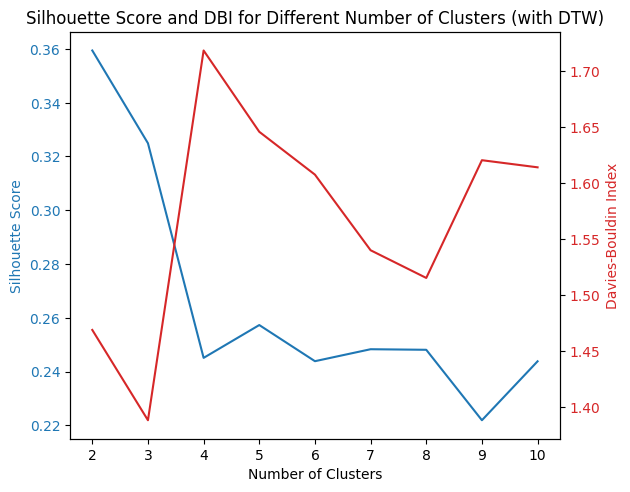

In [170]:


# Transpose the data (if needed) so that rows represent samples and columns are features
data = rlp_aggregated.T

# Define the range of clusters to evaluate
cluster_range = range(2, 11)  # You can adjust this range

# Initialize lists to store the results
silhouette_scores = []
dbi_scores = []
for num_clusters in cluster_range:
    # Perform KMeans clustering with DTW
    kmeans = TimeSeriesKMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    
    # Calculate silhouette score (using tslearn's silhouette function)
    silhouette_avg = silhouette_score(data, labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate Davies-Bouldin Index (using tslearn's DBI function)
    dbi = davies_bouldin_score(data, labels)
    dbi_scores.append(dbi)

# Plotting Silhouette Score and DBI
fig, ax1 = plt.subplots()

# Plot silhouette scores
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color='tab:blue')
ax1.plot(cluster_range, silhouette_scores, color='tab:blue', label='Silhouette Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for DBI
ax2 = ax1.twinx()
ax2.set_ylabel('Davies-Bouldin Index', color='tab:red')
ax2.plot(cluster_range, dbi_scores, color='tab:red', label='Davies-Bouldin Index')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Silhouette Score and DBI for Different Number of Clusters (with DTW)')
plt.show()

In [172]:
print(rlp_aggregated.head())

Date_Cluster  2023-01-01_C1  2023-01-01_C2  2023-01-01_C3  2023-01-01_C4  \
00:00              0.016379       0.016500       0.085464       0.004887   
00:30              0.016394       0.013416       0.079632       0.004883   
01:00              0.016380       0.016263       0.076496       0.004878   
01:30              0.017420       0.011925       0.074201       0.004874   
02:00              0.092198       0.009437       0.074834       0.005788   

Date_Cluster  2023-01-01_C5  2023-01-01_C6  2023-01-01_C7  2023-01-01_C8  \
00:00              0.029432       0.292956       0.042568       0.027163   
00:30              0.047725       0.208274       0.023963       0.038330   
01:00              0.035877       0.226895       0.021193       0.025648   
01:30              0.036646       0.202351       0.025314       0.008422   
02:00              0.038397       0.251619       0.020242       0.008271   

Date_Cluster  2023-01-01_C9  2023-01-02_C1  ...  2023-11-16_C9  2023-11-17_C1  \
00:00

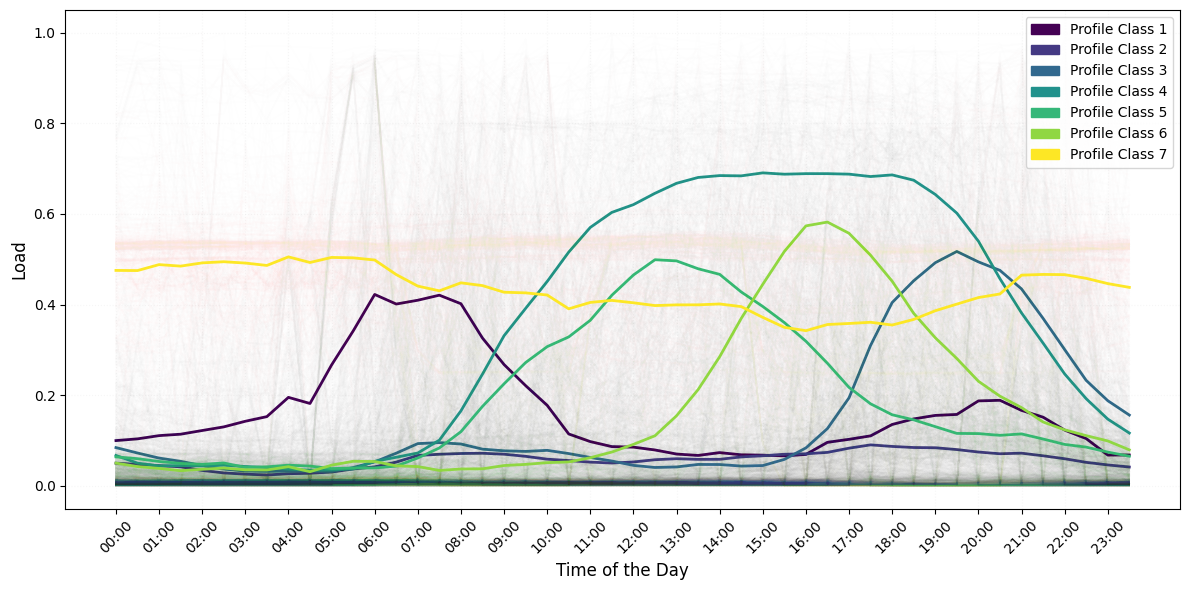

In [171]:
# Apply clustering with optimal number of clusters and create visualization of profile classes
# Apply k-means again so we can create some aggregated Profile Classes
df = rlp_aggregated
data = rlp_aggregated.T
num_clusters = 7
kmeans = TimeSeriesKMeans(num_clusters, random_state=36)
kmeans.fit(data)

# Get the cluster labels assigned to each column (now row in the transposed data)
cluster_labels = kmeans.labels_

# Add the cluster labels back to the original data
data['Cluster'] = cluster_labels
colors = plt.cm.viridis(np.linspace(0, 1, num_clusters))

# Create a DataFrame with cluster labels
Profile_Classes = pd.DataFrame({'Profile_Class': cluster_labels + 1}, index=df.columns)
# Plotting 

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.set_xlabel('Time of the Day', fontsize=12) 
ax.set_ylabel('Load', fontsize=12) 

# Create x-axis values (0 to 47 for 48 half-hour periods) 
x_values = np.arange(48) 

legend_handles = [] 
for i in range(num_clusters): 
    cluster_columns = Profile_Classes[Profile_Classes.Profile_Class == i +1].index 
    cluster_data = df[cluster_columns] 

    # Plot individual observations with low alpha 
    for col in cluster_data.columns: 
        ax.plot(x_values, cluster_data[col], color=colors[i], alpha=0.005) 

    # Plot the mean of the cluster 
    cluster_mean = cluster_data.mean(axis=1) 
    ax.plot(x_values, cluster_mean, color=colors[i], linewidth=2, label=f'Profile Class {i+1}') 

    # Create legend handles 
    legend_handles.append(mpatches.Patch(color=colors[i], label=f'Profile Class {i+1}')) 

# Set x-axis ticks and labels 
ax.set_xticks(range(0, 48, 2)) 
ax.set_xticklabels([f"{i//2:02d}:00" for i in range(0, 48, 2)]) 
ax.tick_params(axis='x', labelrotation=45) 

ax.legend(handles=legend_handles, loc='upper right', fontsize=10) 
ax.grid(True, which='both', linestyle=':', alpha=0.1) 
plt.tight_layout() 
plt.show() 


In [173]:
print(cluster_labels)

[3 1 3 ... 4 1 5]


In [149]:
# Merging profile classes and cluster sites dataframes to get final assignments for each site on each day 
Profile_Classes.index.name = 'Date_Cluster' # set index name to match clusters 
date_range = pd.date_range(start='2023-01-01', end='2023-01-05', freq='D')

# Merge the two dataframes
merged_df = pd.merge(cluster_sites_df, Profile_Classes.reset_index(), on='Date_Cluster')


# Function to extract date from Date_Cluster
def extract_date(date_cluster):
    return pd.to_datetime(date_cluster.split('_')[0]).date()

merged_df['Date'] = merged_df['Date_Cluster'].apply(extract_date)

merged_df = merged_df.drop(columns = 'Date_Cluster')

# Create the final dataframe
final_df = pd.pivot_table(merged_df, values='Profile_Class', index='Date', columns='site_ID', aggfunc='first')

# Reindex with the full date range
final_df = final_df.reindex(date_range)

print(final_df)



site_ID     S0083  S0089  S0106  S0107  S0110  S0111  S0173  S0177  S0179  \
2023-01-01      2      2      2      6      6      2      2      2      6   
2023-01-02      2      2      2      5      2      2      2      2      6   
2023-01-03      2      2      2      2      5      2      2      2      5   
2023-01-04      2      2      2      2      2      2      2      2      5   
2023-01-05      2      2      2      2      2      2      2      2      2   

site_ID     S0188  ...  W0328  W0329  W0332  W0334  W0341  W0342  W0345  \
2023-01-01      2  ...      6      2      4      2      6      2      6   
2023-01-02      6  ...      2      5      4      2      6      2      2   
2023-01-03      4  ...      2      2      2      6      4      2      6   
2023-01-04      2  ...      5      2      2      2      2      2      2   
2023-01-05      2  ...      2      2      2      2      2      2      2   

site_ID     W0346  W0348  W0352  
2023-01-01      6      6      6  
2023-01-02      5 

In [150]:

final_df.to_csv('final_profile_class_assignments.csv')

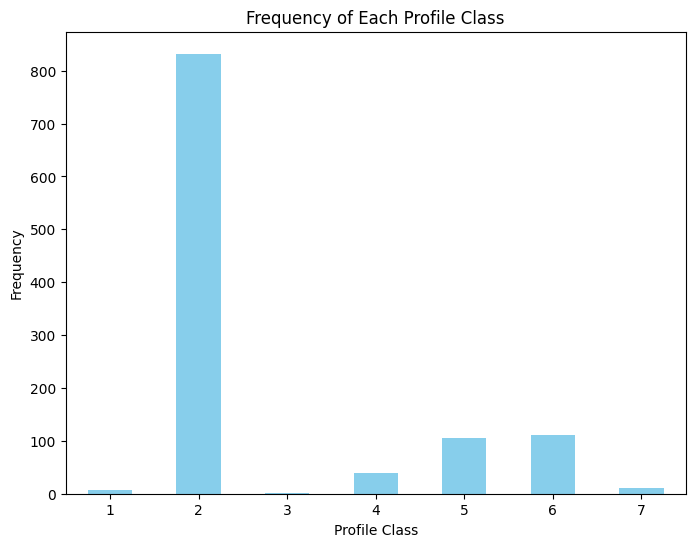

In [153]:
# Create figure of how many observations belong in each profile class 
frequency_counts = final_df.values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Profile Class')
plt.xticks(rotation=0)
plt.show()

In [185]:

# Assuming 'combined_df' is your DataFrame with Timestamp as the first column
#combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])  # Ensure the Timestamp column is datetime
#combined_df.set_index('Timestamp', inplace=True)  # Set Timestamp as index


min_cons = 0.004

# Create an empty list to store the results
low_consumption_sites = []

# Iterate through each site (column) in the DataFrame
for site_id in combined_df.columns:
    # Resample the site data by day and check if all values are <= 0.001 for each day
    daily_max = combined_df[site_id].resample('D').max()  # Get the max value for each day
    
    # Find days where the max value for the day is <= min_cons
    low_consumption_days = daily_max[daily_max <= min_cons].index
    
    # Record the site_id and the days that meet the condition
    for day in low_consumption_days:
        low_consumption_sites.append((site_id, day))

# Convert the list of results to a DataFrame for better visualization
results_df = pd.DataFrame(low_consumption_sites, columns=['Site_ID', 'Date'])

# Display the result
print(results_df)


      Site_ID       Date
0       S0083 2023-01-03
1       S0083 2023-01-06
2       S0083 2023-01-07
3       S0083 2023-01-08
4       S0083 2023-01-10
...       ...        ...
20567   W0348 2023-12-24
20568   W0348 2023-12-25
20569   W0348 2023-12-26
20570   W0348 2023-12-28
20571   W0348 2023-12-30

[20572 rows x 2 columns]


In [186]:
# Assuming the second dataframe is called 'df_to_modify'

modified_final = final_df.copy()

# Iterate over the rows in 'results_df', which contains Site_ID and Date
for idx, row in results_df.iterrows():
    site_id = row['Site_ID']  # Get the site ID (column name in df_to_modify)
    date = row['Date']  # Get the date (index in df_to_modify)
    
    # Check if the date exists in df_to_modify and if the site_id (column) exists
    if date in modified_final.index and site_id in modified_final.columns:
        # Replace the value with 0
        modified_final.at[date, site_id] = 0

# Display the updated dataframe
print(modified_final)


site_ID     S0083  S0089  S0106  S0107  S0110  S0111  S0173  S0177  S0179  \
2023-01-01      2      0      2      6      6      0      2      0      6   
2023-01-02      2      0      2      5      0      0      0      0      6   
2023-01-03      0      0      2      0      5      2      0      0      5   
2023-01-04      2      0      2      0      0      2      2      0      5   
2023-01-05      2      0      2      0      0      2      2      2      2   

site_ID     S0188  ...  W0328  W0329  W0332  W0334  W0341  W0342  W0345  \
2023-01-01      2  ...      6      2      4      0      6      2      6   
2023-01-02      6  ...      0      5      4      0      6      2      2   
2023-01-03      4  ...      0      2      2      6      4      2      6   
2023-01-04      2  ...      5      2      2      0      2      2      2   
2023-01-05      0  ...      2      2      2      0      2      2      2   

site_ID     W0346  W0348  W0352  
2023-01-01      6      6      6  
2023-01-02      5 

In [195]:
# Create figure of how many observations belong in each profile class 
frequency_counts = modified_final.values.flatten().tolist()
print(len(frequency_counts))

1105


In [ ]:

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Profile Class')
plt.xticks(rotation=0)
plt.show()